# Climate Change Sonification
## Exploratory Data Analysis

In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from netCDF4 import Dataset
from scipy import signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import animation 
from IPython.display import HTML, Image
from matplotlib import rcParams
rcParams["font.family"] = "Times New Roman"
rcParams["savefig.dpi"] = 300
# rcParams['animation.html'] = 'html5'

In [2]:
def process_data(frequency):
    PATH = f"data/{frequency}/"
    files = sorted([ f for f in os.listdir(path=PATH) if f.endswith(".nc4") ])
    print(len(files), "files to be read.")

    co2_data = []
    for f in tqdm(files):
        try:
            co2_data.append(Dataset(PATH + f).variables["XCO2"][:])
        except:
            pass
    print(len(files) - len(co2_data), "files could not be read.")
    print("Size:", sum([sys.getsizeof(d) for d in co2_data]), "bytes")

    return co2_data, files


def animate_co2(frequency="monthly", savepath=None):

    # set up plotting area
    fig, ax = plt.subplots()
    ax.tick_params(
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False
    )

    # colorbar
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cmap = mpl.cm.inferno
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = mpl.colorbar.ColorbarBase(
        cax, 
        cmap=cmap,
        norm=norm,
        orientation="vertical"
    )

    def plot_img(data):
        """Plot CO2 values"""
#         data = np.flip(data, axis=0)
        im = ax.pcolormesh(
            data,
            cmap=cmap, 
            vmin=vmin, 
            vmax=vmax,
            animated=True,
            rasterized=True
        )
        return im, 

    # for blitting (optimized raster image animation)
    im, = plot_img(co2_data[0][0,:,:])

    def update(i):  
        im, = plot_img(co2_data[i][0,:,:])

        # axis title
        if frequency == "daily":
            date = files[i].split("_")[4]
            ax.set_title(date[-2:] + " - " + date[-4:-2] + " - " + date[:-4])
        elif frequency == "monthly":
            date = files[i].split("_")[4]
            ax.set_title(date[-2:] + " - " + date[:-2])
        return im,

    # animate
    ani = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(files), 
        interval=500, 
        repeat=True, 
        repeat_delay=1000,
        blit=True 
    )

    # save and display
    plt.tight_layout()
    
    if savepath is not None:
        ani.save(savepath, writer="imagemagick")
    
    return ani

In [3]:
def der(means):
    deriv = [0]
    for i in range(len(means)-1):
        deriv.append(means[i+1]-means[i])
    return deriv

dates_monthly = np.array(pd.date_range(start='01/2015', end='11/2021', freq='M'))
dates_daily = np.array(pd.date_range(start='01/2015', end='11/2021', freq='d'))[:-2]

### Monthly Data

In [4]:
co2_data, files = process_data("monthly")
vmin = min([ d.min() for d in co2_data ])
vmax = max([ d.max() for d in co2_data ])

  0%|          | 0/82 [00:00<?, ?it/s]/Users/irisfolpmers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
  6%|▌         | 5/82 [00:00<00:01, 43.15it/s]

82 files to be read.


100%|██████████| 82/82 [00:02<00:00, 40.16it/s]

0 files could not be read.
Size: 14432 bytes


In [5]:
# Global statistics
means = np.array([ d.mean() for d in co2_data ])
stds = np.array([ d.std() for d in co2_data ])
mins = np.array([ d.min() for d in co2_data ])
maxs = np.array([ d.max() for d in co2_data ])

## Plot Iris

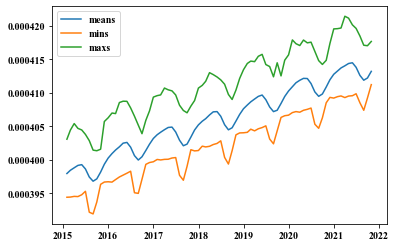

In [6]:
# dates = np.array(pd.date_range(start='01/2015', end='11/2021', freq='M'))
plt.plot(dates_monthly, means, label="means")
# plt.plot(dates, stds, label="stds")
plt.plot(dates_monthly, mins, label="mins")
plt.plot(dates_monthly, maxs, label="maxs")
plt.legend()
plt.show()

## detrended means

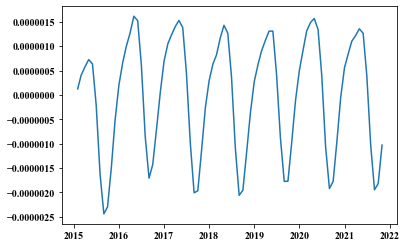

In [7]:

means_detrended = signal.detrend(means)
plt.plot(dates_monthly, means_detrended)
plt.show()

## Regions

In [8]:
co2_data_np = np.array(co2_data)
# print(co2_data_np.shape) # (82, 1, 361, 576)
shape = list(co2_data_np.shape)
first = shape[2]/4
second = 2*shape[2]/4
third = 3*shape[2]/4


first_part = co2_data_np[:, :, 0:int(shape[2]/2), 0:int(shape[3]/2)]
second_part = co2_data_np[:, :, int(shape[2]/2):, 0:int(shape[3]/2)]
third_part = co2_data_np[:, :, 0:int(shape[2]/2), int(shape[3]/2):]
fourth_part = co2_data_np[:, :, int(shape[2]/2):, int(shape[3]/2):]
northern_part = co2_data_np[:, :, 0:int(shape[2]/2), :]

In [9]:
def calculate_all(part):
    means = np.array([ d.mean() for d in part ])
    stds = np.array([ d.std() for d in part ])
    mins = np.array([ d.min() for d in part ])
    maxs = np.array([ d.max() for d in part ])
    return means, stds, mins, maxs

first_means, first_stds, first_mins, first_maxs = calculate_all(first_part)  
second_means, second_stds, second_mins, second_maxs = calculate_all(second_part)
third_means, third_stds, third_mins, third_maxs = calculate_all(third_part)
fourth_means, fourth_stds, fourth_mins, fourth_maxs = calculate_all(fourth_part)

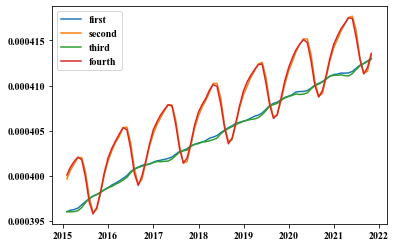

In [10]:
plt.plot(dates_monthly, first_means, label="first")
plt.plot(dates_monthly, second_means, label="second")
plt.plot(dates_monthly, third_means, label="third")
plt.plot(dates_monthly, fourth_means, label="fourth")
plt.legend()
plt.show()

## Derivatives

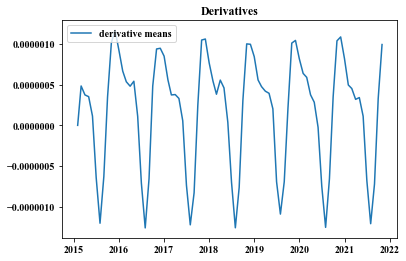

In [11]:

deriv_means = der(means)
deriv_std = der(stds)
deriv_min = der(mins)
deriv_max = der(maxs)
plt.plot(dates_monthly, deriv_means, label="derivative means")
# plt.plot(dates, deriv_std, label="derivative std")
# plt.plot(dates, deriv_min, label="derivative min")
# plt.plot(dates, deriv_max, label="derivative max")
plt.title("Derivatives")
plt.legend()
plt.show()

## Northern Hemisphere

<IPython.core.display.Javascript object>


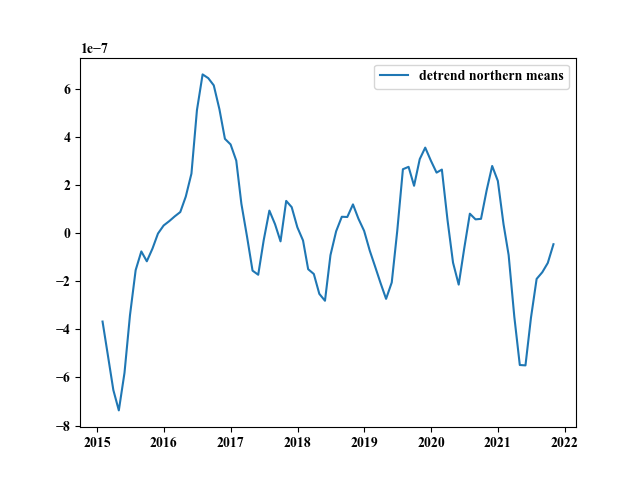

In [46]:
northern_means, northern_stds, northern_mins, northern_maxs = calculate_all(northern_part)  

# Upper means, stds, mins and maxs
_, ax5 = plt.subplots()
# ax5.plot(dates_monthly, northern_means, label="upper means")
# # ax5.plot(dates_monthly, northern_stds, label="upper stds")
# ax5.plot(dates_monthly, northern_mins, label="upper mins")
# ax5.plot(dates_monthly, northern_maxs, label="upper maxs")

# Derivatives of upper means, stds, mins and maxs
# ax5.plot(dates_monthly, der(northern_means), label="deriv upper means")
# ax5.plot(dates_monthly, der(northern_stds), label="deriv upper stds")
# ax5.plot(dates_monthly, der(northern_mins), label="deriv upper mins")
# ax5.plot(dates_monthly, der(northern_maxs), label="deriv upper maxs")

# Detrended upper means, stds, mins and maxs
ax5.plot(dates_monthly, signal.detrend(northern_means), label="detrend northern means")
# ax5.plot(dates_monthly, signal.detrend(northern_stds), label="detrended northern stds")
# ax5.plot(dates_monthly, signal.detrend(northern_mins), label="detrend northern mins")
# ax5.plot(dates_monthly, signal.detrend(northern_maxs), label="detrend upper maxs")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


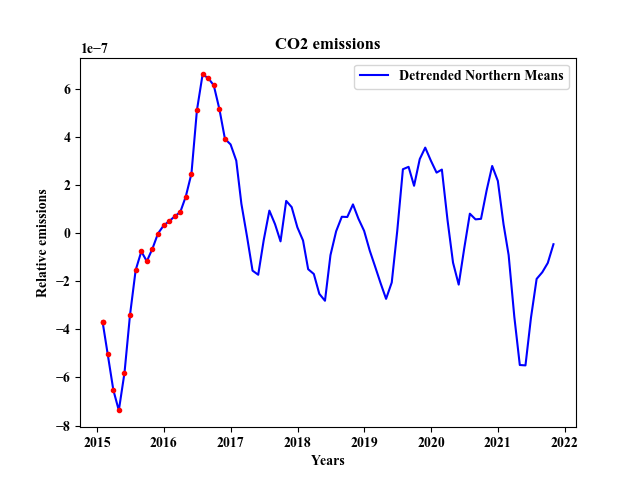

In [38]:
%matplotlib notebook

fig, ax = plt.subplots()
ax.plot(dates_monthly, signal.detrend(northern_means), label="Detrended Northern Means", color="blue")

def animate(i):
    return ax.plot(dates_monthly[i], [signal.detrend(northern_means)[i]], 'r.', label="dot")

myAnimation = animation.FuncAnimation(fig, animate, frames=len(signal.detrend(northern_means)), interval=100, blit=True, repeat=True)

plt.title("CO2 emissions")
plt.xlabel("Years")
plt.ylabel("Relative emissions")
plt.legend()
plt.show()

# Sonification

## Astronify

In [29]:
from astronify.series import SoniSeries
from astropy.table import Table

# means
data_table = Table({"time": range(len(northern_means)),
                    "flux": northern_means})

data_soni = SoniSeries(data_table)
data_soni.note_spacing = 0.3
data_soni.sonify()
# data_soni.play()
# data_soni.write("astronify.wav")

In [43]:
data_table1 = Table({"time": range(len(signal.detrend(northern_means))),
                    "flux": signal.detrend(northern_means)})

data_soni1 = SoniSeries(data_table1)
data_soni1.note_spacing = 0.3
data_soni1.sonify()
data_soni1.play()


data_table2 = Table({"time": range(len(northern_means)),
                    "flux": northern_means})

data_soni2 = SoniSeries(data_table2)
data_soni2.note_spacing = 0.3
data_soni2.sonify()
data_soni2.play()


Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.
Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


<IPython.core.display.Javascript object>


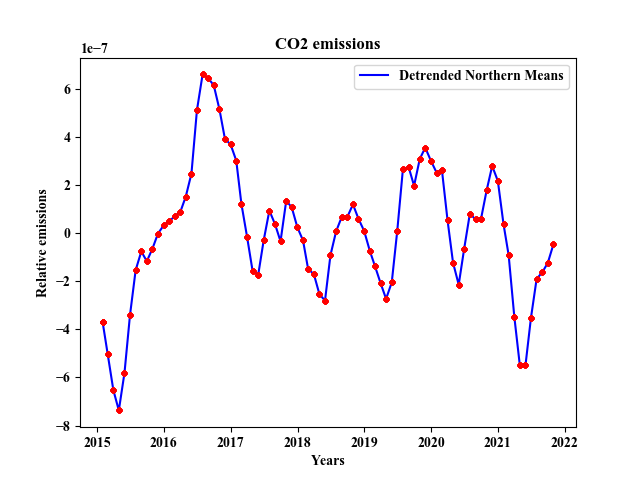

Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


In [40]:
import time

# detrended northern means
data_table = Table({"time": range(len(signal.detrend(northern_means))),
                    "flux": signal.detrend(northern_means)})

data_soni = SoniSeries(data_table)
data_soni.note_spacing = 0.3
data_soni.sonify()


fig, ax = plt.subplots()
ax.plot(dates_monthly, signal.detrend(northern_means), label="Detrended Northern Means", color="blue")
myAnimation = animation.FuncAnimation(fig, animate, frames=len(signal.detrend(northern_means)), interval=290, blit=True, repeat=True)


plt.legend()
plt.title("CO2 emissions")
plt.xlabel("Years")
plt.ylabel("Relative emissions")
plt.show()

# time.sleep(2)
# x=2021
data_soni.play()

## Sonipy

In [41]:
from sonipy.sonify import SonifyTool

# global means
Tone = SonifyTool(range(len(means)), means)
# Tone.play()
# Tone.save()


multitones created


In [42]:
# global means
C4 = 161.6 # Hz
frequency_args = {
  'frequency_min' : C4,
  'frequency_max' : C4*4
  # 'cents_per_value' : -680,
  # 'value_min' : 0,
  # 'value_max' : 1,
}

duration_args = {
  'time_total' : 20000, # ms
  # 'time_min' : 100, # ms
  # 'time_max' : 800, # ms
}

duration_scale = 1. / 20000. # x value / time (ms)

Tone = SonifyTool(means, range(len(means)),
                  frequency_args = frequency_args,
                  duration_args = duration_args,
                  # duration_scale = duration_scale,
                  bliplength=1.1)

Tone.play()
# Tone.save()

multitones created


multitones created


<IPython.core.display.Javascript object>


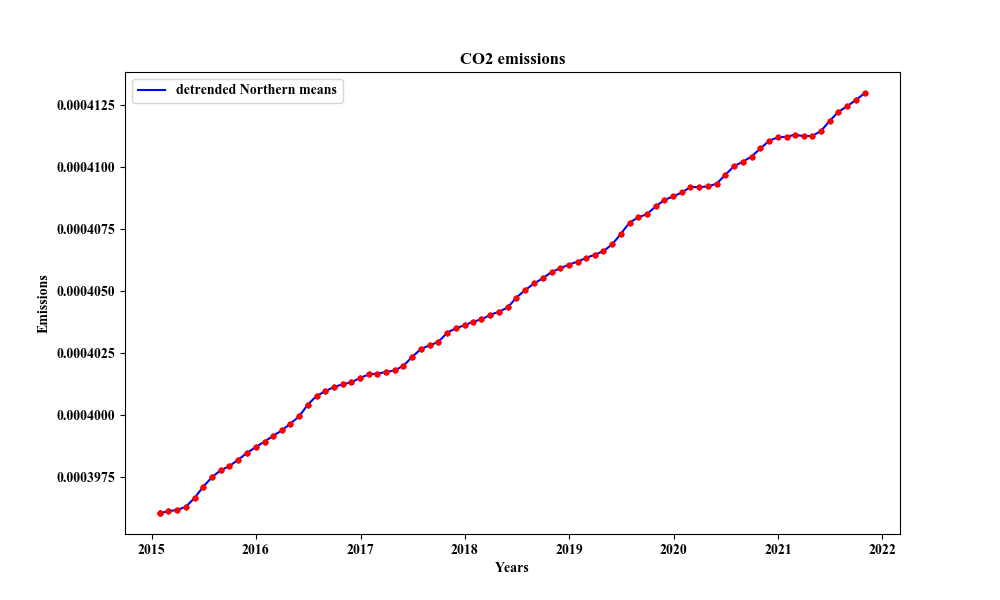

In [57]:
# northern means
C4 = 200
frequency_args = {
  'frequency_min' : C4,
  'frequency_max' : C4*4
}

duration_args = {
  'time_total' : 20000
}


Tone = SonifyTool(northern_means, range(len(northern_means)),
                  frequency_args = frequency_args,
                  duration_args = duration_args,
                  bliplength=1.1)



def animate(i):
    return ax.plot(dates_monthly[i], [northern_means[i]], 'r.', label="dot")

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dates_monthly, northern_means, label="detrended Northern means", color="blue")
myAnimation = animation.FuncAnimation(fig, animate, frames=len(northern_means), interval=260, blit=True, repeat=True)


plt.legend()
plt.title("CO2 emissions")
plt.xlabel("Years")
plt.ylabel("Emissions")
plt.show()
Tone.play()


In [95]:
print(signal.detrend(upper_means)*10**7)

[-3.67559335 -5.02140253 -6.52174697 -7.36917052 -5.8066591  -3.40996333
 -1.53832483 -0.76002074 -1.17056353 -0.64182948 -0.01740422  0.31832401
  0.50067693  0.69269     0.87746423  1.51929659  2.47479845  5.10990262
  6.59854738  6.442037    6.14367619  5.14821267  3.92006822  3.6872119
  3.01356554  1.21967773 -0.15108557 -1.55939874 -1.72992457 -0.29560406
  0.93635214  0.3705911  -0.34204322  1.33954864  1.08044434  0.24222746
 -0.30534772 -1.4988683  -1.69872302 -2.52364642 -2.81115672 -0.91438731
  0.07784873  0.68028074  0.67102652  1.19451291  0.59738092  0.09357728
 -0.73400067 -1.36651322 -2.0796074  -2.73218988 -2.05020909  0.0882003
  2.65699706  2.75598994  1.96833833  3.07644545  3.5553638   3.01080432
  2.51560003  2.64171974  0.53508773 -1.22651843 -2.14082798 -0.64485013
  0.80832676  0.57210864  0.59403516  1.78844963  2.79168557  2.1704592
  0.3737752  -0.91188213 -3.47419627 -5.48152846 -5.4980391  -3.52077465
 -1.90309472 -1.62554234 -1.23975765 -0.46093073]


multitones created


<IPython.core.display.Javascript object>


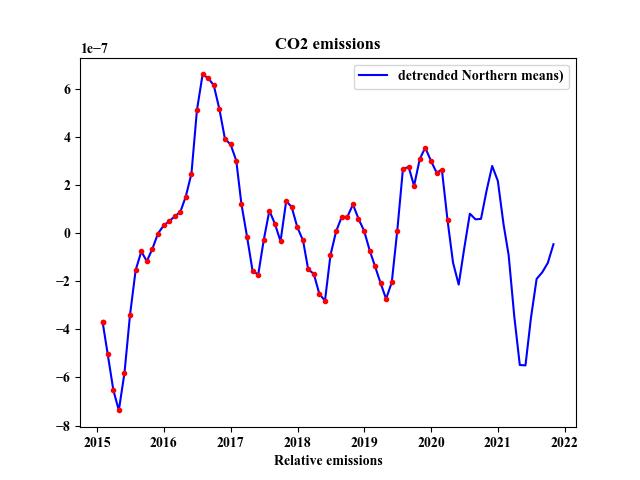

In [96]:
# detrended northern means
frequency_args = {
  'frequency_min' : 200,
  'frequency_max' : 200*2
}

duration_args = {
  'time_total' : 20000
}


Tone = SonifyTool(signal.detrend(upper_means)*10**7, range(len(signal.detrend(upper_means))),
                  frequency_args = frequency_args,
                  duration_args = duration_args,
                  bliplength=1.1)

def animate(i):
    return ax.plot(dates[i], [signal.detrend(upper_means)[i]], 'r.', label="dot")

fig, ax = plt.subplots()
ax.plot(dates, signal.detrend(upper_means), label="detrended Northern means)", color="blue")
myAnimation = animation.FuncAnimation(fig, animate, frames=len(signal.detrend(upper_means)), interval=300, blit=True, repeat=True)


plt.legend()
plt.title("CO2 emissions")
plt.xlabel("Years")
plt.xlabel("Relative emissions")
plt.show()

Tone.play()

# Daily (veeeery slow)

In [17]:
# co2_data, files = process_data("daily")
# vmin = min([ d.min() for d in co2_data ])
# vmax = max([ d.max() for d in co2_data ])

In [18]:
# # Global statistics
# means = np.array([ d.mean() for d in co2_data ])
# stds = np.array([ d.std() for d in co2_data ])
# mins = np.array([ d.min() for d in co2_data ])
# maxs = np.array([ d.max() for d in co2_data ])

In [19]:
# _, ax = plt.subplots(figsize=(16,9))

# x = np.arange(len(co2_data))

# xmin = x.min()
# xmax = x.max()
# ymin = mins.min()
# ymax = maxs.max()

# k = 10
# X = np.arange(k * k).reshape(k,k)
# ax.imshow(X, interpolation='bicubic', cmap=mpl.cm.inferno_r,
#           extent=(xmin, xmax, ymin, ymax), alpha=1, aspect='auto')

# ax.plot(means, lw=2, c="black")

# # standard deviations
# ax.fill_between(x, means, means + stds, facecolor="white", alpha=.5)
# ax.fill_between(x, means, means - stds, facecolor="white", alpha=.5)

# # extrema
# ax.fill_between(x, means, mins, facecolor="white", alpha=.25)
# ax.fill_between(x, means, maxs, facecolor="white", alpha=.25)

# ax.set_ylim(ymin, ymax)
# ax.set_title("XCO$_2$ Global Average")
# plt.savefig("daily_global_average.png")
# plt.show()

# Iris

In [20]:
# print(np.array(co2_data).shape)
# dates_day = np.array(pd.date_range(start='01/2015', end='11/2021', freq='d'))

In [21]:
# shape = np.array(co2_data).shape

In [22]:
# _, ax = plt.subplots(figsize=(16,9))
# ax.plot(dates_day[:-2], der(means))
# plt.show()

## Northern Hemisphere

In [23]:
# shape = np.array(co2_data).shape
# north = np.array(co2_data)[:, :, 0:int(shape[2]/2), :]


In [24]:
# _, ax = plt.subplots(figsize=(16,9))
# ax.plot(dates_daily, der(north))
# plt.show()